In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

In [2]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

    self.x0_boundary, self.x1_boundary, self.t_boundaries, self.t0_boundary, self.x_boundary = self.init_boundaries()

    self.x_rms, self.t_rms = self.rms_sample()
    self.c_analytic = torch.tensor(self.TransientAnalyticSoln(self.x_rms.cpu().detach().numpy(), self.t_rms.cpu().detach().numpy())).to(device)

    self.D = torch.nn.Parameter(torch.tensor(0.).to(device), requires_grad=True)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x
  
  # exact solution of modelling coursework
  def TransientAnalyticSoln(self, x_rms, t_rms):

    sol = []
    for i in range(len(x_rms)):
      x = x_rms[i]
      t = t_rms[i]  
      trans = 0
      for k in range(1, 1001):
          trans += ((((-1)**k)/k) * np.exp(-k**2*np.pi**2*t)*np.sin(k*np.pi*x))
      c = x + (2/np.pi)*trans
      sol.append(c)
    return sol
  
  def TransientAnalyticSolnPLot(self, x_rms, t_rms):

    sol = np.zeros((len(x_rms), len(t_rms)))
    for i in range(len(x_rms)):
      x = x_rms[i]
      for j in range(len(t_rms)):
        t = t_rms[j]  
        trans = 0
        for k in range(1, 1001):
            trans += ((((-1)**k)/k) * np.exp(-k**2*np.pi**2*t)*np.sin(k*np.pi*x))
        c = x + (2/np.pi)*trans
        sol[i, j] = c
    return sol
  
  def init_boundaries(self):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    x0_boundary = torch.tensor(0.).repeat(100).view(-1, 1).requires_grad_(True).to(device)
    x1_boundary = torch.tensor(1.).repeat(100).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(100).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(100).view(-1, 1).requires_grad_(True).to(device)
    x_boundary = torch.rand(100).view(-1, 1).requires_grad_(True).to(device)

    return x0_boundary, x1_boundary, t_boundaries, t0_boundary, x_boundary
  
  def physics_sample(self):
      
      # sample points for training
      x = torch.rand(50).view(-1, 1).requires_grad_(True).to(device)
      t = torch.rand(50).view(-1, 1).requires_grad_(True).to(device)
  
      return x, t
  
  def rms_sample(self):
        
        # sample points for training
        x = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)
        t = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)
    
        return x, t
  
  def c_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def c_rr(self, c, r):
    c_r = self.c_r(c, r)
    return torch.autograd.grad(c_r, r, grad_outputs=torch.ones_like(c_r).to(device), create_graph=True)[0]
  
  def c_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def losses(self):

    x_phys, t_phys = self.physics_sample()
    D = self.D

    # losses for x and t boundaries
    c = self.forward(self.x0_boundary, self.t_boundaries)
    t0_loss = c

    c = self.forward(self.x1_boundary, self.t_boundaries)
    x1_loss = (c-1)**2
    
    c = self.forward(self.x_boundary, self.t0_boundary)
    x0_loss = c

    c = self.forward(x_phys, t_phys)
    c_rr = self.c_rr(c, x_phys)
    c_t = self.c_t(c, t_phys)

    phys_loss = c_t - D*c_rr
    
  
    c = self.forward(self.x_rms, self.t_rms)
    rms_loss = (c - self.c_analytic)
    
    loss = 1e-2 * (torch.mean(x0_loss**2) + torch.mean(x1_loss**2) + torch.mean(t0_loss**2) + torch.mean(phys_loss**2)) + torch.mean(rms_loss**2)  

    return loss
  
  def closure(self):
    self.lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs, lr, epochs_lbfgs):

    # initialise parameters and optimiser
    D = torch.nn.Parameter(torch.tensor(0.).to(device), requires_grad=True)
    Ds = [] 
    losses = []
    optimizer = torch.optim.Adam(list(self.parameters())+[D], lr = lr)

    self.lbfgs = torch.optim.LBFGS(list(self.parameters())+[D], 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    

    for epoch in range(epochs):
      
      optimizer.zero_grad()
      # find loss
      loss = self.losses()

      self.D = D

      # store parameter and loss values
      Ds.append(D.item())
      losses.append(loss.item())
      # backpropagation
      loss.backward()
      optimizer.step()
      # print loss and parameter values
      print(f'Epoch: {epoch}  Loss: {loss.item()}, D: {self.D.item()}', end='\r')

    for epoch in range(epochs_lbfgs):
      self.D = D
      losses.append(loss.item())
      loss = self.lbfgs.step(self.closure)
      Ds.append(self.D.item())

      print(f'Epoch: {epochs + epoch}  Loss: {loss.item()}, D: {self.D.item()}', end='\r')
       

      
    self.plot(Ds, losses)

    return Ds, losses

  def plot(self, Ds, losses):
      
      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      
      numerical = self.TransientAnalyticSolnPLot(X.cpu().detach().numpy(), T.cpu().detach().numpy())

      X, T = torch.meshgrid(X, T)    
      C = self.forward(X.flatten().unsqueeze(1), T.flatten().unsqueeze(1)).view(100, 100).cpu().detach().numpy()
      error = np.abs((C - numerical)**2)
      
      X, T = X.cpu().detach().numpy(), T.cpu().detach().numpy()
      fig = plt.figure(figsize=(14, 14))


      plt.subplot(2, 2, 1)
      plt.contourf(X, T, C)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('Neural Network Solution')
      plt.colorbar().set_label('Concentration (mol/m^3)')

      plt.subplot(2, 2, 2)
      plt.contourf(X, T, error)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('RMS Error of Neural Network Solution')
      plt.colorbar().set_label('RMS Error (mol/m^3)')

      plt.subplot(2, 2, 3)
      plt.plot(Ds)
      plt.xlabel('Epoch')
      plt.ylabel('D')
      plt.title('D variation with Epochs')
      plt.axhline(y =1 , color = 'black', linestyle = '--')
      plt.grid(True)

      plt.subplot(2, 2, 4)
      plt.plot(losses)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Loss variation with Epochs')
      plt.grid(True)


      plt.show()
  


c:\Users\twcy2\anaconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


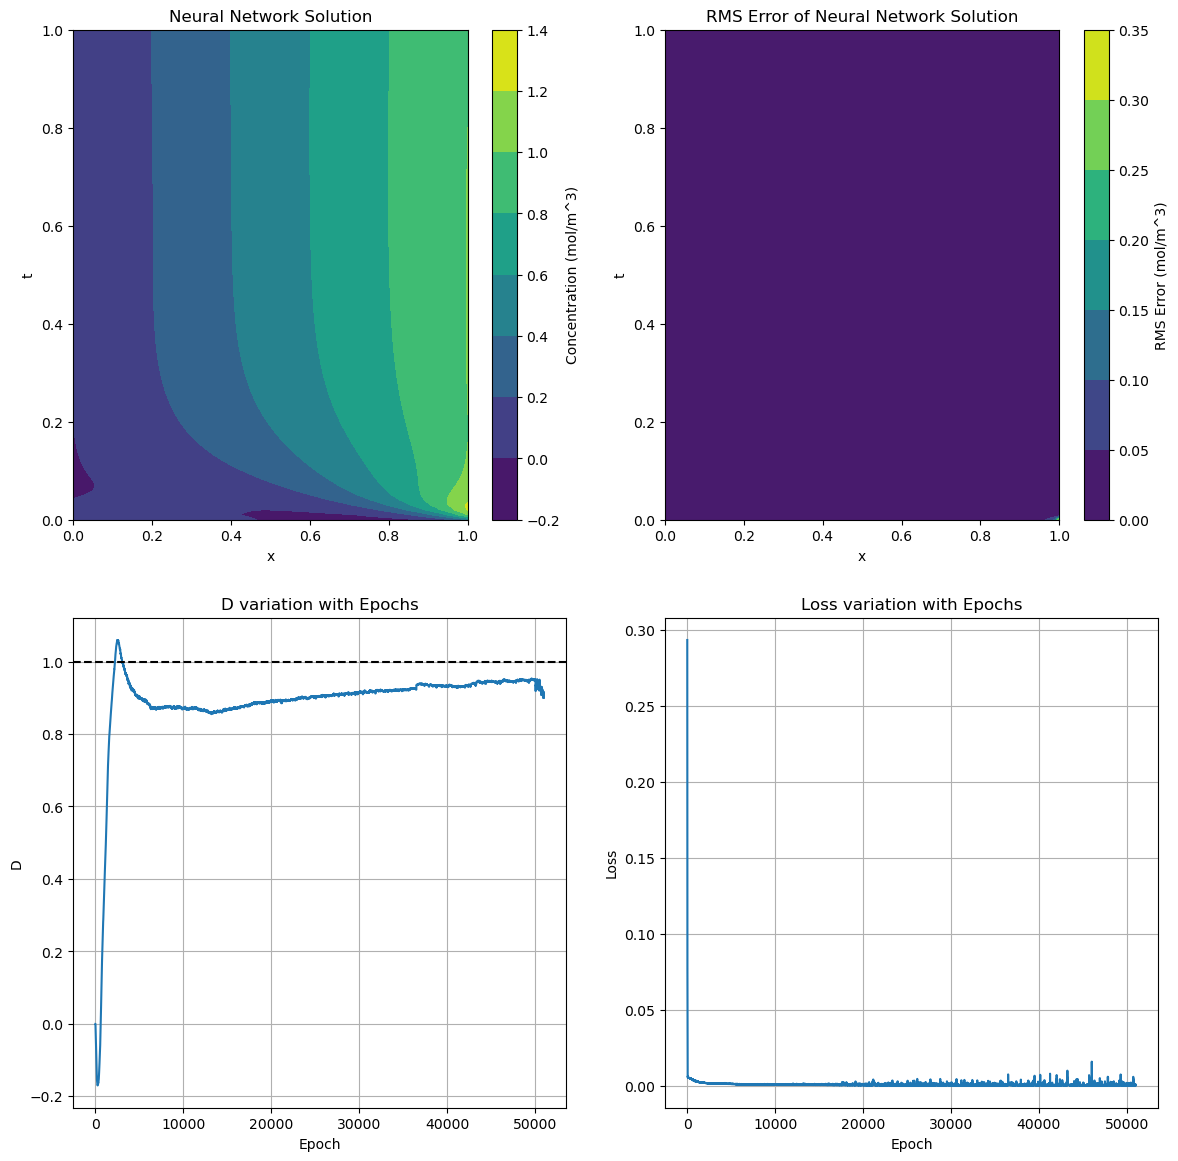

In [4]:
# nn seed

# define nn to train, two inputs for x and t
pinn = Network(2, 3, 32, 1).to(device)

# training things
epochs = 50000
lr = 1e-3


Ds, losses = pinn.train(epochs, lr, 1000)

1.0151629447937012

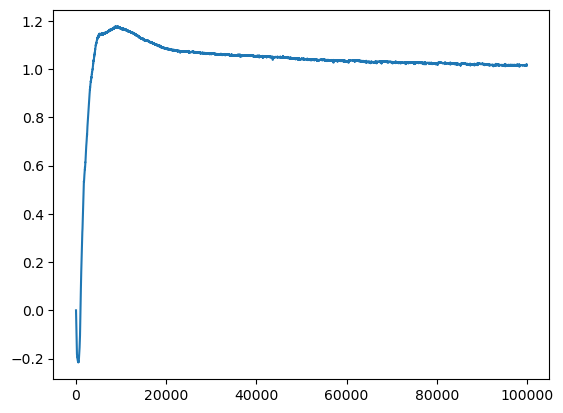

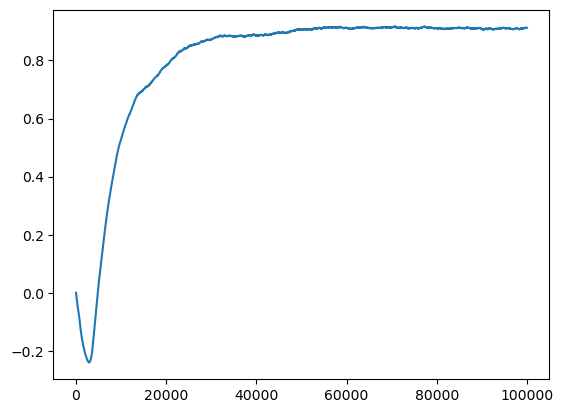

In [36]:
# ds_flattened = [tensor.flatten().detach().numpy() for tensor in Ds]

# plot Ds
plt.plot(Ds)
plt.show()

ValueError: Contour levels must be increasing

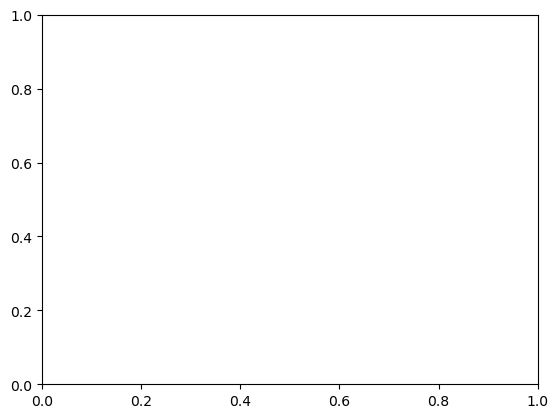

In [8]:
X = torch.linspace(0, 5e-6, 50).to(device)
T = torch.linspace(0, 400, 50).to(device)
X, T = np.meshgrid(X.cpu().numpy(), T.cpu().numpy())